In [2]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
size_of_image = 256
size_of_batch = 16

In [13]:

train_imgs = sorted(glob("/content/drive/MyDrive/train_m/Train/low/*"))[:400]
val_imgs = sorted(glob("/content/drive/MyDrive/train_m/Train/low/*"))[400:]
test_imgs = sorted(glob("/content/drive/MyDrive/train_m/Train/low/*"))[:15]

In [15]:



def preprocess_data(pathofimage):
    image = tf.io.read_file(pathofimage)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[size_of_image, size_of_image])
    image = image / 255.0
    return image


def gen_data(ll_imgs):
    dataset = tf.data.Dataset.from_tensor_slices((ll_imgs))
    dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(size_of_batch, drop_remainder=True)
    return dataset






In [16]:
train_dataset = gen_data(train_imgs)
val_dataset = gen_data(val_imgs)


In [17]:
def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))


In [18]:
def calculate_illumination_smoothness_loss(image_tensor):

    batch_size = tf.shape(image_tensor)[0]
    height = tf.shape(image_tensor)[1]
    width = tf.shape(image_tensor)[2]

    height_elements = (tf.shape(image_tensor)[2] - 1) * tf.shape(image_tensor)[3]
    width_elements = tf.shape(image_tensor)[2] * (tf.shape(image_tensor)[3] - 1)

    height_tv = tf.reduce_sum(tf.square(image_tensor[:, 1:, :, :] - image_tensor[:, :height - 1, :, :]))
    width_tv = tf.reduce_sum(tf.square(image_tensor[:, :, 1:, :] - image_tensor[:, :, :width - 1, :]))

    batch_size = tf.cast(batch_size, dtype=tf.float32)
    height_elements = tf.cast(height_elements, dtype=tf.float32)
    width_elements = tf.cast(width_elements, dtype=tf.float32)

    return 2 * (height_tv / height_elements + width_tv / width_elements) / batch_size


In [19]:

def compute_color_consistency_loss(image):

    mean_values = tf.reduce_mean(image, axis=(1, 2), keepdims=True)
    red_mean, green_mean, blue_mean = mean_values[:, :, :, 0], mean_values[:, :, :, 1], mean_values[:, :, :, 2]

    diff_red_green = tf.square(red_mean - green_mean)
    diff_red_blue = tf.square(red_mean - blue_mean)
    diff_green_blue = tf.square(blue_mean - green_mean)

    return tf.sqrt(diff_red_green + diff_red_blue + diff_green_blue)



In [8]:

def build_custom_dce_net():

    input_img = keras.Input(shape=[None, None, 3])

    conv1 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(input_img)
    conv2 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(conv1)
    conv3 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(conv2)
    conv4 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(conv3)

    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])

    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(int_con3)

    model = keras.Model(inputs=input_img, outputs=x_r)
    return model


In [21]:
class ConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(ConsistencyLoss, self).__init__(reduction="none")

        self.kernel_left = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.kernel_right = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.kernel_up = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.kernel_down = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, true_values, predicted_values):

        mean_true = tf.reduce_mean(true_values, axis=3, keepdims=True)
        mean_predicted = tf.reduce_mean(predicted_values, axis=3, keepdims=True)


        pooled_true = tf.nn.avg_pool2d(
            mean_true, ksize=4, strides=4, padding="VALID"
        )
        pooled_predicted = tf.nn.avg_pool2d(
            mean_predicted, ksize=4, strides=4, padding="VALID"
        )

        grad_true_left = tf.nn.conv2d(
            pooled_true, self.kernel_left, strides=[1, 1, 1, 1], padding="SAME"
        )
        grad_true_right = tf.nn.conv2d(
            pooled_true, self.kernel_right, strides=[1, 1, 1, 1], padding="SAME"
        )
        grad_true_up = tf.nn.conv2d(
            pooled_true, self.kernel_up, strides=[1, 1, 1, 1], padding="SAME"
        )
        grad_true_down = tf.nn.conv2d(
            pooled_true, self.kernel_down, strides=[1, 1, 1, 1], padding="SAME"
        )

        grad_pred_left = tf.nn.conv2d(
            pooled_predicted, self.kernel_left, strides=[1, 1, 1, 1], padding="SAME"
        )
        grad_pred_right = tf.nn.conv2d(
            pooled_predicted, self.kernel_right, strides=[1, 1, 1, 1], padding="SAME"
        )
        grad_pred_up = tf.nn.conv2d(
            pooled_predicted, self.kernel_up, strides=[1, 1, 1, 1], padding="SAME"
        )
        grad_pred_down = tf.nn.conv2d(
            pooled_predicted, self.kernel_down, strides=[1, 1, 1, 1], padding="SAME"
        )

        diff_left = tf.square(grad_true_left - grad_pred_left)
        diff_right = tf.square(grad_true_right - grad_pred_right)
        diff_up = tf.square(grad_true_up - grad_pred_up)
        diff_down = tf.square(grad_true_down - grad_pred_down)

        return diff_left + diff_right + diff_up + diff_down


In [5]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_custom_dce_net()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.constancy_loss = ConsistencyLoss(reduction="none")

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * calculate_illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(compute_color_consistency_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )
        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )


Epoch 1/100
25/25 [==============================] - 23s 338ms/step - total_loss: 5.3806 - illumination_smoothness_loss: 2.3490 - spatial_constancy_loss: 3.4357e-05 - color_constancy_loss: 0.1066 - exposure_loss: 2.9249 - val_total_loss: 4.8110 - val_illumination_smoothness_loss: 1.7655 - val_spatial_constancy_loss: 2.5081e-05 - val_color_constancy_loss: 0.0451 - val_exposure_loss: 3.0004
Epoch 2/100
25/25 [==============================] - 7s 271ms/step - total_loss: 4.4984 - illumination_smoothness_loss: 1.4730 - spatial_constancy_loss: 3.2501e-05 - color_constancy_loss: 0.1045 - exposure_loss: 2.9209 - val_total_loss: 4.2013 - val_illumination_smoothness_loss: 1.1617 - val_spatial_constancy_loss: 2.9626e-05 - val_color_constancy_loss: 0.0448 - val_exposure_loss: 2.9948
Epoch 3/100
25/25 [==============================] - 8s 298ms/step - total_loss: 4.0629 - illumination_smoothness_loss: 1.0458 - spatial_constancy_loss: 4.1026e-05 - color_constancy_loss: 0.1029 - exposure_loss: 2.914

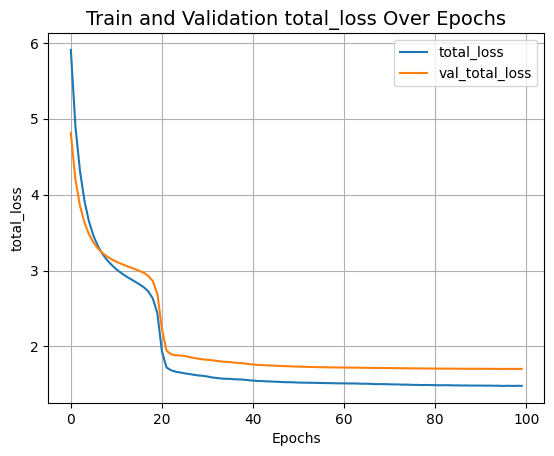

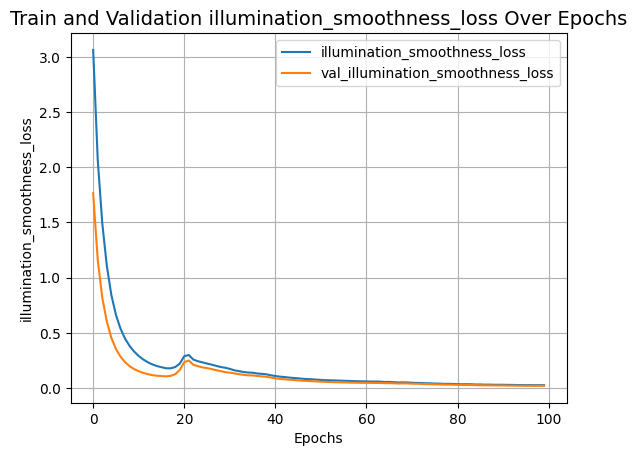

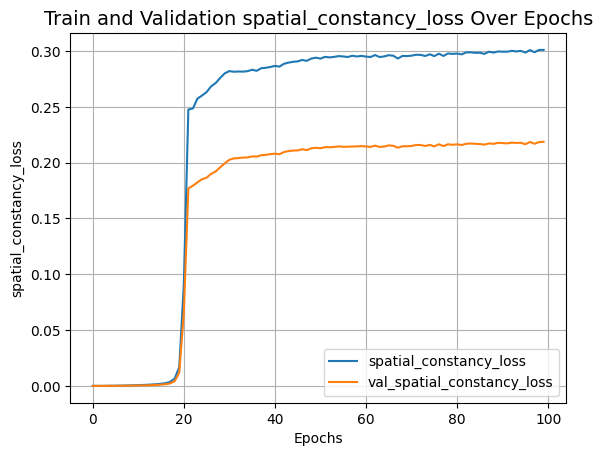

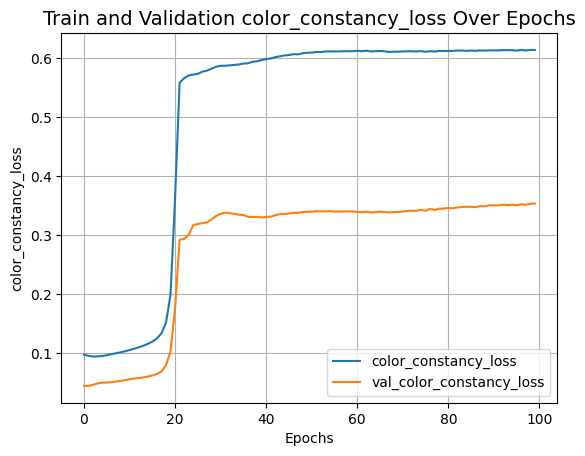

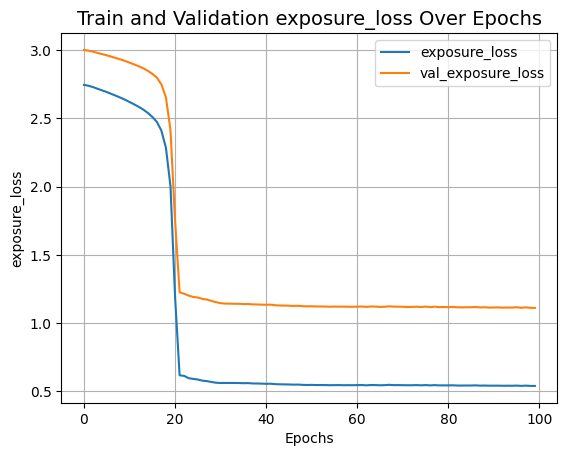

In [23]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-4)
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=100)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

In [15]:
import cv2
def calculate_psnr(original, processed):
    original_array = np.asarray(original)
    processed_array = np.asarray(processed)
    mse = np.mean((original_array - processed_array) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image


In [ ]:
zero_dce_model.save_weights('/content/drive/MyDrive/zerodcemodel.h5')

In [17]:
zero_dce_model = ZeroDCE()
zero_dce_model.load_weights('/content/drive/My Drive/zerodcemodel.h5')

In [18]:

a=[]

for val_image_file in val_imgs[:15]:
    new =val_image_file.replace('low','high')
    new_image = np.array(Image.open(new))
    original_image = Image.open(val_image_file)
    enhanced_image = infer(original_image)
    plt.imshow(enhanced_image)
    plt.show()
    psnr_value = calculate_psnr(new_image,enhanced_image)
    a.append(psnr_value)


print(f"PSNR value is {np.mean(a)} dB")



PSNR value is 27.573045244706755 dB
